In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
torch.set_float32_matmul_precision('high')
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

device = "cuda"

In [2]:
class VAE(nn.Module):
    
    def __init__(self, channels, shape):
        super(VAE, self).__init__()
        self.w = self.h = (((shape-8)//2-4)//2)
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(channels, 16, kernel_size=5, padding=0), nn.BatchNorm2d(16), nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, padding=0), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=0), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=0), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(128 * self.w * self.h, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
        )

        self.embedding = nn.Embedding(10, 64)
        
        self.fc_mu = nn.Sequential(
            nn.Linear(320, 128)
        )
        self.fc_log_var = nn.Sequential(
            nn.Linear(320, 128)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(192, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 128 * self.w * self.h),
            nn.ReLU(),
        )
        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2, padding=0),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=0), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=0), nn.BatchNorm2d(32), nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2, padding=0),
            nn.ConvTranspose2d(32, 16, kernel_size=5, padding=0), nn.BatchNorm2d(16), nn.ReLU(),
            nn.ConvTranspose2d(16, channels, kernel_size=5, padding=0),
            nn.Sigmoid()  # Output values between 0 and 1 for pixel values
        )

    def encode(self, x, y):
        x = self.encoder(x)
        x = torch.cat((x,y),dim=1)
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z, y):
        z = torch.cat((z,y),dim=1)
        z = self.decoder(z)
        z = self.decoder_conv(z.view(-1, 128, self.w, self.h))
        return z
    
    def forward(self, x, y):
        y = self.embedding(y)
        mu, log_var = self.encode(x, y)
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decode(z, y)
        return reconstruction, mu, log_var
        

In [3]:
def train(model, train_set, epochs, batch_size, lr):
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss(reduction = "sum")

    train_losses = []
    
    for epoch in range(epochs):
        print("\nEPOCH: {}".format(epoch+1))
        
        model.train()
        pbar = tqdm(train_loader)
        train_loss = 0

        for batch_idx, (data, target) in enumerate(pbar):

            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            
            X_hat, mean, logvar = model(data, target)

            reconstruction_loss = criterion(X_hat, data)
            KL_divergence = 0.5 * torch.sum(-1 - logvar + torch.exp(logvar) + mean**2)
            loss = reconstruction_loss + KL_divergence
            train_loss += loss.item()

            loss.backward()
            optimizer.step() 
            pbar.set_description(desc= f'Loss={loss.item()/data.shape[0]} Batch_id={batch_idx}')
        
        train_losses.append(train_loss/len(train_loader.dataset))

        print(f'\nAverage Training Loss={train_loss/len(train_loader.dataset)}')

In [4]:
def visualize(model, dataset, map):
    # Set the model to evaluation mode
    model.eval()

    # Load a batch of 20 images from the CIFAR-10 dataset
    batch_size = 25
    sample_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    sample_images, label = next(iter(sample_loader))

    # Pass the images through the VAE
    with torch.no_grad():
        recon_images, _, _ = model(sample_images.to(device), label.to(device))

    # Visualize the original and reconstructed images
    plt.figure(figsize=(10, 20))
    for i in range(batch_size):
        plt.subplot(10, 5, (i//5)*10 + i%5 + 1)
        plt.imshow(sample_images[i].permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.title('Original')
        
        plt.subplot(10, 5, (i//5)*10 + i%5 + 6)
        plt.imshow(recon_images[i].permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.title(f'Reconstruction\n(wrong_label={map[label[i].item()]})')

    plt.tight_layout()
    plt.show()

In [5]:
class DataSet(Dataset):
    def __init__(self, dataset, shape, random=False):
        self.dataset = dataset
        self.shape = shape
        self.random = random

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        new_label = label
        if self.random:
            while new_label==label:
                new_label = torch.randint(10, (1,1))
            new_label = new_label.squeeze(0).squeeze(0)
        # one_hot = torch.nn.functional.one_hot(torch.tensor(new_label), self.shape)
        # one_hot = one_hot.view(1, -1)
        # one_hot_expanded = one_hot.repeat(self.shape, 1)
        # new_image = torch.cat((image, one_hot_expanded.unsqueeze(0)), dim=0)
        return image, new_label

In [6]:
model = VAE(3,32).to(device)
transform = transforms.Compose([transforms.ToTensor()])
train_set = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
dataset = DataSet(train_set, 32)
epochs = 100
batch_size = 128
lr = 1e-3
train(model, dataset, epochs, batch_size, lr)

Files already downloaded and verified

EPOCH: 1


Loss=1934.998828125 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 55.26it/s]    



Average Training Loss=1988.17798125

EPOCH: 2


Loss=1908.65390625 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 58.49it/s]     



Average Training Loss=1920.781530625

EPOCH: 3


Loss=1907.915234375 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 58.03it/s]    



Average Training Loss=1903.1019225

EPOCH: 4


Loss=1873.525390625 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.65it/s]    



Average Training Loss=1896.1961315625

EPOCH: 5


Loss=1876.208203125 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.84it/s]    



Average Training Loss=1886.243519375

EPOCH: 6


Loss=1888.556640625 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 59.62it/s]    



Average Training Loss=1880.6740025

EPOCH: 7


Loss=1862.07421875 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 57.12it/s]     



Average Training Loss=1874.681063125

EPOCH: 8


Loss=1822.932421875 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 59.97it/s]    



Average Training Loss=1871.4999234375

EPOCH: 9


Loss=1871.1966796875 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 55.91it/s]   



Average Training Loss=1868.6527896875

EPOCH: 10


Loss=1869.3720703125 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 57.67it/s]   



Average Training Loss=1867.4475415625

EPOCH: 11


Loss=1876.8685546875 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 57.08it/s]   



Average Training Loss=1865.5013721875

EPOCH: 12


Loss=1845.9751953125 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 57.45it/s]   



Average Training Loss=1864.116370625

EPOCH: 13


Loss=1887.244140625 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.78it/s]    



Average Training Loss=1862.9836759375

EPOCH: 14


Loss=1871.609765625 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 57.90it/s]    



Average Training Loss=1861.529725

EPOCH: 15


Loss=1895.251171875 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.80it/s]    



Average Training Loss=1860.6202609375

EPOCH: 16


Loss=1874.1576171875 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 57.52it/s]   



Average Training Loss=1860.1035503125

EPOCH: 17


Loss=1860.3392578125 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 57.03it/s]   



Average Training Loss=1859.253258125

EPOCH: 18


Loss=1891.019921875 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 57.37it/s]    



Average Training Loss=1859.216834375

EPOCH: 19


Loss=1825.5474609375 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.77it/s]   



Average Training Loss=1858.6181359375

EPOCH: 20


Loss=1829.0748046875 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 57.63it/s]   



Average Training Loss=1858.325131875

EPOCH: 21


Loss=1867.421875 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 57.31it/s]       



Average Training Loss=1857.402486875

EPOCH: 22


Loss=1816.2361328125 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 57.58it/s]   



Average Training Loss=1856.9778578125

EPOCH: 23


Loss=1851.2140625 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 57.21it/s]      



Average Training Loss=1856.635756875

EPOCH: 24


Loss=1837.0955078125 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 57.49it/s]   



Average Training Loss=1856.22319375

EPOCH: 25


Loss=1797.04453125 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 57.71it/s]     



Average Training Loss=1855.96778625

EPOCH: 26


Loss=1906.9125 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 57.09it/s]         



Average Training Loss=1855.79722

EPOCH: 27


Loss=1830.830859375 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.80it/s]    



Average Training Loss=1855.417946875

EPOCH: 28


Loss=1864.93828125 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.89it/s]     



Average Training Loss=1855.223740625

EPOCH: 29


Loss=1851.14296875 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 57.48it/s]     



Average Training Loss=1854.8654934375

EPOCH: 30


Loss=1847.75546875 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 57.27it/s]     



Average Training Loss=1854.0224209375

EPOCH: 31


Loss=1855.7875 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.71it/s]         



Average Training Loss=1854.415421875

EPOCH: 32


Loss=1871.7244140625 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 57.05it/s]   



Average Training Loss=1853.6848653125

EPOCH: 33


Loss=1804.7185546875 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 57.09it/s]   



Average Training Loss=1853.4170521875

EPOCH: 34


Loss=1803.8138671875 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 57.27it/s]   



Average Training Loss=1853.1159821875

EPOCH: 35


Loss=1837.74609375 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 57.06it/s]     



Average Training Loss=1852.6999634375

EPOCH: 36


Loss=1874.922265625 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.99it/s]    



Average Training Loss=1852.4574115625

EPOCH: 37


Loss=1844.1966796875 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.80it/s]   



Average Training Loss=1852.197573125

EPOCH: 38


Loss=1833.473828125 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 57.51it/s]    



Average Training Loss=1851.6310175

EPOCH: 39


Loss=1862.546875 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.34it/s]       



Average Training Loss=1851.2685440625

EPOCH: 40


Loss=1881.498828125 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.46it/s]    



Average Training Loss=1851.391465

EPOCH: 41


Loss=1849.5095703125 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.96it/s]   



Average Training Loss=1850.8921153125

EPOCH: 42


Loss=1825.550390625 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 57.19it/s]    



Average Training Loss=1851.01996625

EPOCH: 43


Loss=1842.45390625 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 57.84it/s]     



Average Training Loss=1850.580150625

EPOCH: 44


Loss=1855.7958984375 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 52.06it/s]   



Average Training Loss=1850.3500715625

EPOCH: 45


Loss=1871.7623046875 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 54.58it/s]   



Average Training Loss=1850.107919375

EPOCH: 46


Loss=1836.857421875 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 54.61it/s]    



Average Training Loss=1849.9704575

EPOCH: 47


Loss=1882.7453125 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 54.26it/s]      



Average Training Loss=1849.6905046875

EPOCH: 48


Loss=1810.40234375 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 51.95it/s]     



Average Training Loss=1849.3312453125

EPOCH: 49


Loss=1856.7470703125 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 54.43it/s]   



Average Training Loss=1849.1219090625

EPOCH: 50


Loss=1890.3138671875 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 55.32it/s]   



Average Training Loss=1848.5252190625

EPOCH: 51


Loss=1825.50390625 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 55.51it/s]     



Average Training Loss=1848.243598125

EPOCH: 52


Loss=1860.766015625 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 54.95it/s]    



Average Training Loss=1848.3341634375

EPOCH: 53


Loss=1808.06171875 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 55.97it/s]     



Average Training Loss=1847.976194375

EPOCH: 54


Loss=1882.4052734375 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.88it/s]   



Average Training Loss=1847.9193278125

EPOCH: 55


Loss=1876.149609375 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 57.16it/s]    



Average Training Loss=1847.3951046875

EPOCH: 56


Loss=1823.9943359375 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.95it/s]   



Average Training Loss=1847.1605475

EPOCH: 57


Loss=1865.6642578125 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.37it/s]   



Average Training Loss=1847.01008625

EPOCH: 58


Loss=1851.26484375 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.79it/s]     



Average Training Loss=1846.64666625

EPOCH: 59


Loss=1777.2603515625 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.93it/s]   



Average Training Loss=1846.3502734375

EPOCH: 60


Loss=1849.318359375 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.38it/s]    



Average Training Loss=1846.4290159375

EPOCH: 61


Loss=1849.3736328125 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.39it/s]   



Average Training Loss=1846.100213125

EPOCH: 62


Loss=1868.5517578125 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.25it/s]   



Average Training Loss=1845.7759659375

EPOCH: 63


Loss=1838.4359375 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.65it/s]      



Average Training Loss=1845.5847471875

EPOCH: 64


Loss=1877.275 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.01it/s]          



Average Training Loss=1845.5240246875

EPOCH: 65


Loss=1864.7458984375 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.23it/s]   



Average Training Loss=1845.3532790625

EPOCH: 66


Loss=1856.8634765625 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 55.75it/s]   



Average Training Loss=1845.044373125

EPOCH: 67


Loss=1835.333984375 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.66it/s]    



Average Training Loss=1844.8418940625

EPOCH: 68


Loss=1813.6669921875 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.84it/s]   



Average Training Loss=1844.493270625

EPOCH: 69


Loss=1859.112109375 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 55.49it/s]    



Average Training Loss=1844.6249434375

EPOCH: 70


Loss=1865.3875 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 55.46it/s]         



Average Training Loss=1844.2601571875

EPOCH: 71


Loss=1832.915234375 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 51.75it/s]    



Average Training Loss=1843.808130625

EPOCH: 72


Loss=1879.3982421875 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 52.56it/s]   



Average Training Loss=1843.7415403125

EPOCH: 73


Loss=1875.0861328125 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 54.66it/s]   



Average Training Loss=1843.63674125

EPOCH: 74


Loss=1832.258203125 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 55.89it/s]    



Average Training Loss=1843.2993296875

EPOCH: 75


Loss=1893.7748046875 Batch_id=390: 100%|██████████| 391/391 [00:06<00:00, 56.55it/s]   



Average Training Loss=1843.1039403125

EPOCH: 76


Loss=1816.6828125 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 55.82it/s]      



Average Training Loss=1843.065696875

EPOCH: 77


Loss=1842.9060546875 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 54.79it/s]   



Average Training Loss=1842.754901875

EPOCH: 78


Loss=1873.734375 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 55.50it/s]       



Average Training Loss=1842.494598125

EPOCH: 79


Loss=1844.848046875 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 55.28it/s]    



Average Training Loss=1842.4456646875

EPOCH: 80


Loss=1831.748046875 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 55.41it/s]    



Average Training Loss=1842.369505

EPOCH: 81


Loss=1811.06484375 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 55.69it/s]     



Average Training Loss=1842.2136140625

EPOCH: 82


Loss=1873.4201171875 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 55.43it/s]   



Average Training Loss=1841.598926875

EPOCH: 83


Loss=1871.0458984375 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 55.60it/s]   



Average Training Loss=1841.63700125

EPOCH: 84


Loss=1811.621875 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 55.80it/s]       



Average Training Loss=1841.6115946875

EPOCH: 85


Loss=1839.501953125 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 55.78it/s]    



Average Training Loss=1841.1645778125

EPOCH: 86


Loss=1859.96796875 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 54.58it/s]     



Average Training Loss=1841.08932125

EPOCH: 87


Loss=1843.0880859375 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 55.39it/s]   



Average Training Loss=1840.803994375

EPOCH: 88


Loss=1872.201171875 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 55.19it/s]    



Average Training Loss=1840.7846853125

EPOCH: 89


Loss=1818.1658203125 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 55.42it/s]   



Average Training Loss=1840.7744565625

EPOCH: 90


Loss=1791.5095703125 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 55.26it/s]   



Average Training Loss=1840.3264340625

EPOCH: 91


Loss=1854.8953125 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 54.59it/s]      



Average Training Loss=1840.536048125

EPOCH: 92


Loss=1849.6767578125 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 55.47it/s]   



Average Training Loss=1840.26928625

EPOCH: 93


Loss=1875.2376953125 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 55.70it/s]   



Average Training Loss=1840.0356203125

EPOCH: 94


Loss=1863.04375 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 54.53it/s]        



Average Training Loss=1839.551486875

EPOCH: 95


Loss=1876.5455078125 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 54.13it/s]   



Average Training Loss=1839.8334903125

EPOCH: 96


Loss=1804.47578125 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 54.62it/s]     



Average Training Loss=1839.3951684375

EPOCH: 97


Loss=1782.515625 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 55.35it/s]       



Average Training Loss=1839.4358434375

EPOCH: 98


Loss=1862.471484375 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 54.60it/s]    



Average Training Loss=1839.364584375

EPOCH: 99


Loss=1868.5236328125 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 55.38it/s]   



Average Training Loss=1839.1081996875

EPOCH: 100


Loss=1870.774609375 Batch_id=390: 100%|██████████| 391/391 [00:07<00:00, 55.48it/s]    


Average Training Loss=1838.7216046875


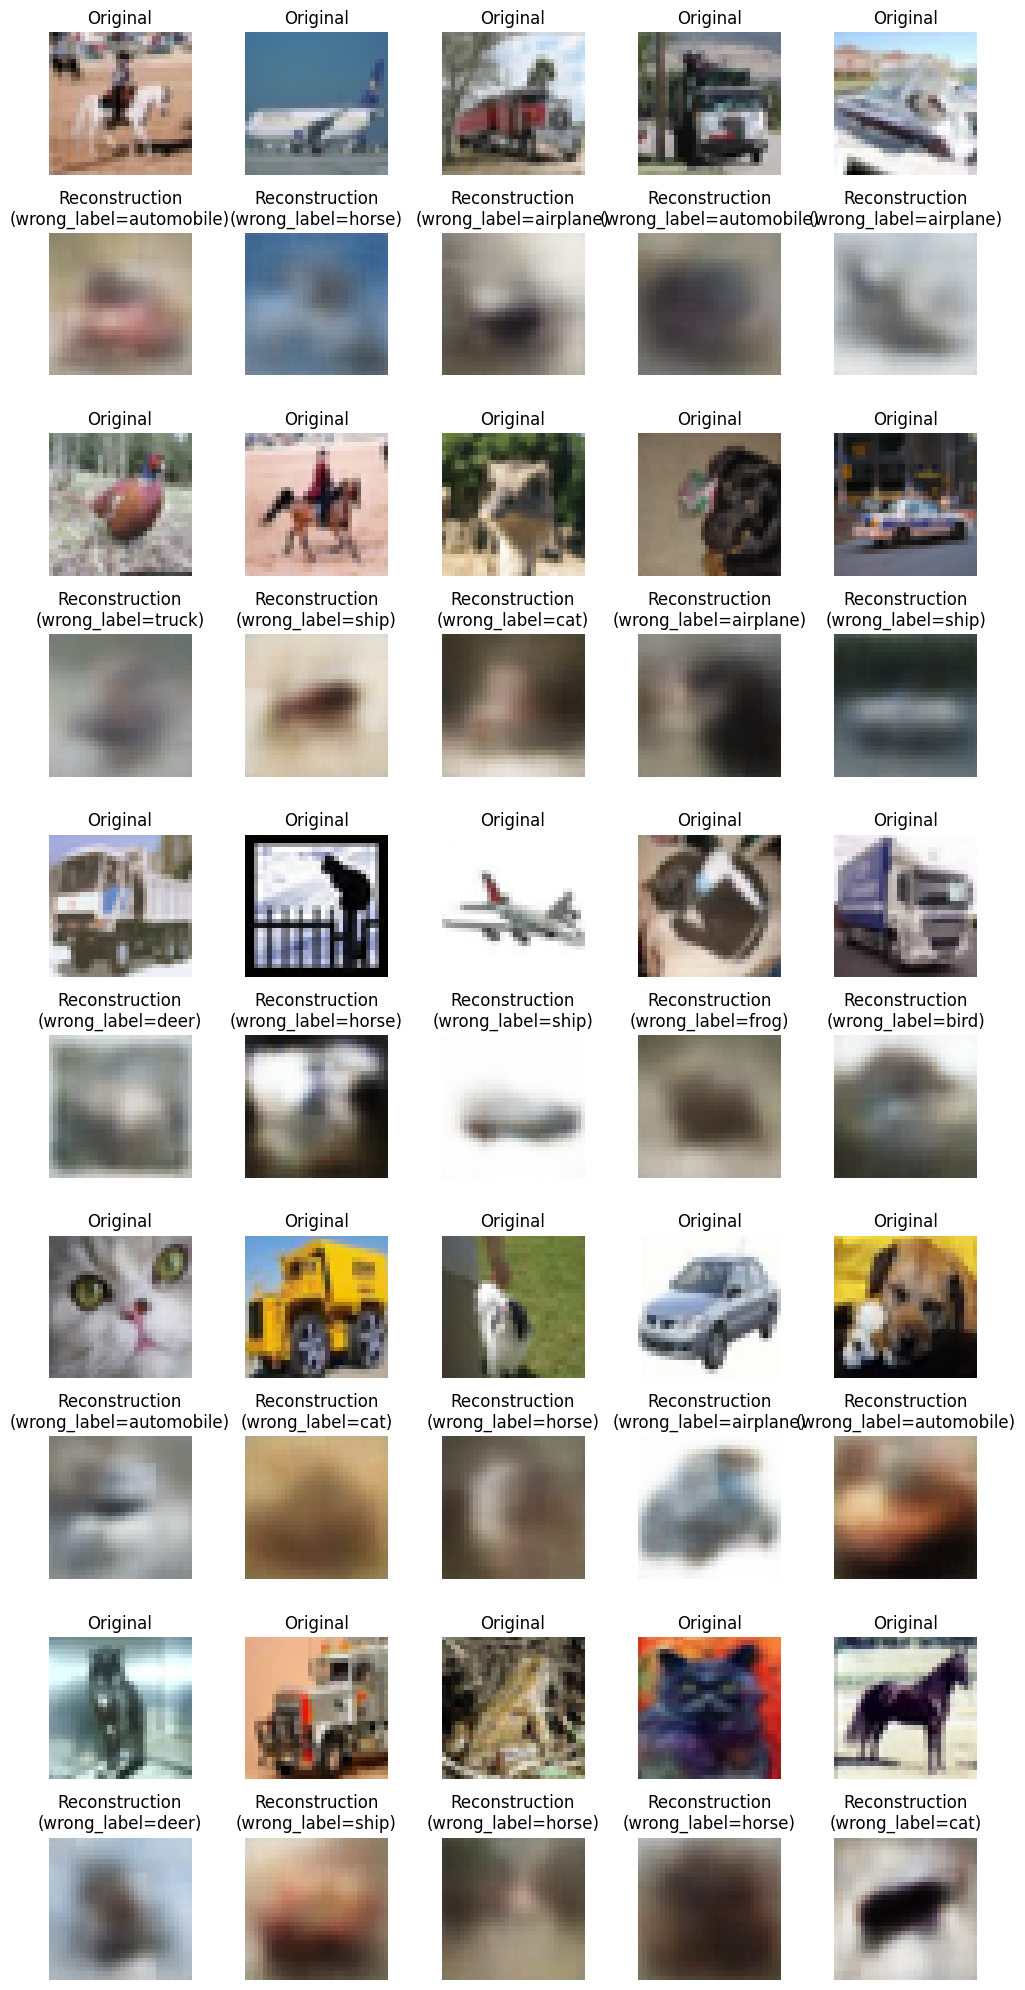

In [7]:
cifar10_map = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}
dataset = DataSet(train_set, 32, True)
visualize(model, dataset, cifar10_map)

In [8]:
model = VAE(1,28).to(device)
transform = transforms.Compose([transforms.ToTensor()])
train_set = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataset = DataSet(train_set, 28)
epochs = 100
batch_size = 128
lr = 1e-3
train(model, dataset, epochs, batch_size, lr)


EPOCH: 1


Loss=131.51925659179688 Batch_id=468: 100%|██████████| 469/469 [00:07<00:00, 64.89it/s]



Average Training Loss=155.32242364908853

EPOCH: 2


Loss=114.10709635416667 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 71.26it/s]



Average Training Loss=120.45333766276042

EPOCH: 3


Loss=110.31685384114583 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 71.78it/s]



Average Training Loss=109.96031829427083

EPOCH: 4


Loss=114.7867431640625 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 70.84it/s] 



Average Training Loss=106.21556658528645

EPOCH: 5


Loss=107.53074137369792 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 71.73it/s]



Average Training Loss=103.87135201822916

EPOCH: 6


Loss=100.25904337565105 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 69.77it/s]



Average Training Loss=102.30897210286459

EPOCH: 7


Loss=101.87113444010417 Batch_id=468: 100%|██████████| 469/469 [00:07<00:00, 66.57it/s]



Average Training Loss=101.32786160481771

EPOCH: 8


Loss=97.1564229329427 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 68.45it/s]  



Average Training Loss=100.29293422851562

EPOCH: 9


Loss=98.3432108561198 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 68.91it/s]  



Average Training Loss=99.5570145670573

EPOCH: 10


Loss=99.82520548502605 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 67.20it/s] 



Average Training Loss=99.10405236002605

EPOCH: 11


Loss=93.66482543945312 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 67.57it/s] 



Average Training Loss=98.7296938639323

EPOCH: 12


Loss=94.03539021809895 Batch_id=468: 100%|██████████| 469/469 [00:07<00:00, 66.49it/s] 



Average Training Loss=98.08954202473959

EPOCH: 13


Loss=97.09054565429688 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 69.22it/s] 



Average Training Loss=97.84582677408854

EPOCH: 14


Loss=98.31840006510417 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 75.83it/s] 



Average Training Loss=97.47248551432291

EPOCH: 15


Loss=100.99819946289062 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 67.87it/s]



Average Training Loss=97.15706337890624

EPOCH: 16


Loss=99.14408365885417 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 69.38it/s] 



Average Training Loss=96.80983336588541

EPOCH: 17


Loss=93.3175048828125 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 75.60it/s]  



Average Training Loss=96.55790541992188

EPOCH: 18


Loss=100.387939453125 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 75.16it/s]  



Average Training Loss=96.39269396158855

EPOCH: 19


Loss=93.2943115234375 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 72.83it/s]  



Average Training Loss=96.02435226236979

EPOCH: 20


Loss=93.4826151529948 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 69.18it/s]  



Average Training Loss=95.87852127278646

EPOCH: 21


Loss=94.12381998697917 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 67.77it/s] 



Average Training Loss=95.52165083007813

EPOCH: 22


Loss=96.50027465820312 Batch_id=468: 100%|██████████| 469/469 [00:07<00:00, 63.52it/s] 



Average Training Loss=95.44564440104166

EPOCH: 23


Loss=95.75687662760417 Batch_id=468: 100%|██████████| 469/469 [00:07<00:00, 64.66it/s] 



Average Training Loss=95.14730402018229

EPOCH: 24


Loss=91.3175760904948 Batch_id=468: 100%|██████████| 469/469 [00:07<00:00, 64.04it/s]  



Average Training Loss=95.00055073242187

EPOCH: 25


Loss=97.90833536783855 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 70.21it/s] 



Average Training Loss=94.83868002929688

EPOCH: 26


Loss=95.78656005859375 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 74.98it/s] 



Average Training Loss=94.74681725260416

EPOCH: 27


Loss=99.17709350585938 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 73.91it/s] 



Average Training Loss=94.50541139322917

EPOCH: 28


Loss=94.37117513020833 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 74.37it/s]



Average Training Loss=94.33333175455729

EPOCH: 29


Loss=91.1258544921875 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 74.55it/s]  



Average Training Loss=94.202086328125

EPOCH: 30


Loss=95.42852783203125 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 74.50it/s] 



Average Training Loss=94.15148321940104

EPOCH: 31


Loss=93.88203938802083 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 74.02it/s] 



Average Training Loss=94.05853486328125

EPOCH: 32


Loss=97.16849772135417 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 74.57it/s] 



Average Training Loss=93.68429046223959

EPOCH: 33


Loss=90.74664306640625 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 73.42it/s] 



Average Training Loss=93.77541411132813

EPOCH: 34


Loss=95.9739481608073 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 71.73it/s]  



Average Training Loss=93.57769609375

EPOCH: 35


Loss=93.616455078125 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 68.51it/s]   



Average Training Loss=93.44320706380208

EPOCH: 36


Loss=98.98389689127605 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 67.21it/s]



Average Training Loss=93.30646632486979

EPOCH: 37


Loss=91.31646728515625 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 67.56it/s] 



Average Training Loss=93.24853206380209

EPOCH: 38


Loss=93.68048095703125 Batch_id=468: 100%|██████████| 469/469 [00:07<00:00, 66.99it/s] 



Average Training Loss=93.20417019856771

EPOCH: 39


Loss=93.60239664713542 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 68.51it/s] 



Average Training Loss=92.98165994466146

EPOCH: 40


Loss=90.0592041015625 Batch_id=468: 100%|██████████| 469/469 [00:07<00:00, 64.45it/s]  



Average Training Loss=92.96010027669271

EPOCH: 41


Loss=95.31034342447917 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 67.55it/s]



Average Training Loss=92.7969246907552

EPOCH: 42


Loss=90.37618001302083 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 70.61it/s] 



Average Training Loss=92.739435546875

EPOCH: 43


Loss=95.89771525065105 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 75.65it/s] 



Average Training Loss=92.60805823567708

EPOCH: 44


Loss=90.34307861328125 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 72.99it/s]



Average Training Loss=92.50563299153646

EPOCH: 45


Loss=93.45589192708333 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 69.56it/s]



Average Training Loss=92.40342452799479

EPOCH: 46


Loss=89.18868001302083 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 76.19it/s] 



Average Training Loss=92.37877490234375

EPOCH: 47


Loss=93.07614135742188 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 76.84it/s]



Average Training Loss=92.24367014973959

EPOCH: 48


Loss=90.5043233235677 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 76.44it/s] 



Average Training Loss=92.14704360351563

EPOCH: 49


Loss=90.53715006510417 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 76.40it/s] 



Average Training Loss=92.18417180989583

EPOCH: 50


Loss=92.54996744791667 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 69.37it/s]



Average Training Loss=91.99207631835938

EPOCH: 51


Loss=91.40167236328125 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 68.21it/s]



Average Training Loss=91.91476197916667

EPOCH: 52


Loss=93.15282185872395 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 70.05it/s]



Average Training Loss=91.8143909342448

EPOCH: 53


Loss=90.576904296875 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 72.69it/s]  



Average Training Loss=91.83587963867187

EPOCH: 54


Loss=93.92630004882812 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 67.05it/s]



Average Training Loss=91.7080485514323

EPOCH: 55


Loss=92.07340494791667 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 68.22it/s] 



Average Training Loss=91.637928125

EPOCH: 56


Loss=95.58131917317708 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 68.09it/s]



Average Training Loss=91.62477986653646

EPOCH: 57


Loss=93.67378743489583 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 76.57it/s]



Average Training Loss=91.49788561197917

EPOCH: 58


Loss=93.3429667154948 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 77.16it/s] 



Average Training Loss=91.37050787760417

EPOCH: 59


Loss=93.14312744140625 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 76.67it/s]



Average Training Loss=91.37172970377604

EPOCH: 60


Loss=90.88742065429688 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 76.08it/s]



Average Training Loss=91.3238251953125

EPOCH: 61


Loss=92.6564229329427 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 72.47it/s]  



Average Training Loss=91.2625208984375

EPOCH: 62


Loss=97.52459716796875 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 73.44it/s]



Average Training Loss=91.18109837239584

EPOCH: 63


Loss=94.73846435546875 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 68.47it/s]



Average Training Loss=91.10434275716146

EPOCH: 64


Loss=91.5367431640625 Batch_id=468: 100%|██████████| 469/469 [00:07<00:00, 66.99it/s] 



Average Training Loss=91.11347055664062

EPOCH: 65


Loss=93.70987955729167 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 68.17it/s]



Average Training Loss=90.93698097330729

EPOCH: 66


Loss=91.1123046875 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 69.25it/s]    



Average Training Loss=90.99584104817708

EPOCH: 67


Loss=94.75576782226562 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 67.86it/s]



Average Training Loss=90.86087921549479

EPOCH: 68


Loss=92.8743387858073 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 67.52it/s] 



Average Training Loss=90.875471484375

EPOCH: 69


Loss=91.01312255859375 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 67.91it/s]



Average Training Loss=90.70156360677083

EPOCH: 70


Loss=92.6162109375 Batch_id=468: 100%|██████████| 469/469 [00:07<00:00, 66.17it/s]    



Average Training Loss=90.74277386067709

EPOCH: 71


Loss=87.67622884114583 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 74.19it/s]



Average Training Loss=90.67857013346354

EPOCH: 72


Loss=94.47166951497395 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 76.03it/s]



Average Training Loss=90.55321168619791

EPOCH: 73


Loss=89.30609130859375 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 76.64it/s]



Average Training Loss=90.54989246419271

EPOCH: 74


Loss=89.05021158854167 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 72.40it/s]



Average Training Loss=90.53874532877605

EPOCH: 75


Loss=90.96170043945312 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 67.37it/s]



Average Training Loss=90.45301028645834

EPOCH: 76


Loss=89.49770100911458 Batch_id=468: 100%|██████████| 469/469 [00:07<00:00, 63.48it/s]



Average Training Loss=90.45925152994792

EPOCH: 77


Loss=89.4092305501302 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 71.56it/s] 



Average Training Loss=90.33992568359375

EPOCH: 78


Loss=93.07523600260417 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 70.28it/s]



Average Training Loss=90.28023444010417

EPOCH: 79


Loss=91.93180338541667 Batch_id=468: 100%|██████████| 469/469 [00:07<00:00, 65.74it/s]



Average Training Loss=90.19833766276042

EPOCH: 80


Loss=92.38219197591145 Batch_id=468: 100%|██████████| 469/469 [00:07<00:00, 63.91it/s]



Average Training Loss=90.18368686523438

EPOCH: 81


Loss=88.7333475748698 Batch_id=468: 100%|██████████| 469/469 [00:07<00:00, 64.07it/s] 



Average Training Loss=90.19128824869792

EPOCH: 82


Loss=90.17307535807292 Batch_id=468: 100%|██████████| 469/469 [00:07<00:00, 66.39it/s]



Average Training Loss=90.0145633951823

EPOCH: 83


Loss=89.677001953125 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 67.42it/s]  



Average Training Loss=90.08671508789062

EPOCH: 84


Loss=89.17732747395833 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 70.60it/s]



Average Training Loss=90.03568745117188

EPOCH: 85


Loss=89.7008056640625 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 69.20it/s] 



Average Training Loss=89.99361778971354

EPOCH: 86


Loss=90.4065653483073 Batch_id=468: 100%|██████████| 469/469 [00:07<00:00, 64.69it/s] 



Average Training Loss=89.9992005045573

EPOCH: 87


Loss=91.78538004557292 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 74.53it/s]



Average Training Loss=89.94559490559895

EPOCH: 88


Loss=92.36644490559895 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 75.62it/s]



Average Training Loss=89.80851056315105

EPOCH: 89


Loss=89.20119222005208 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 73.93it/s]



Average Training Loss=89.73671774088541

EPOCH: 90


Loss=89.18187459309895 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 69.99it/s] 



Average Training Loss=89.703521875

EPOCH: 91


Loss=91.73656209309895 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 74.66it/s]



Average Training Loss=89.70294404296875

EPOCH: 92


Loss=87.2091776529948 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 72.79it/s] 



Average Training Loss=89.6668946451823

EPOCH: 93


Loss=86.3350118001302 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 74.02it/s] 



Average Training Loss=89.62882923177084

EPOCH: 94


Loss=90.69986979166667 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 72.32it/s]



Average Training Loss=89.5545735514323

EPOCH: 95


Loss=88.87490844726562 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 74.53it/s]



Average Training Loss=89.51369736328125

EPOCH: 96


Loss=91.13327026367188 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 73.56it/s]



Average Training Loss=89.46704737955729

EPOCH: 97


Loss=88.89546712239583 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 73.11it/s]



Average Training Loss=89.35357928059896

EPOCH: 98


Loss=88.99593098958333 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 75.98it/s]



Average Training Loss=89.38992088216146

EPOCH: 99


Loss=94.64026896158855 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 75.60it/s]



Average Training Loss=89.46243894856771

EPOCH: 100


Loss=91.96370442708333 Batch_id=468: 100%|██████████| 469/469 [00:06<00:00, 72.18it/s]


Average Training Loss=89.34591896158854


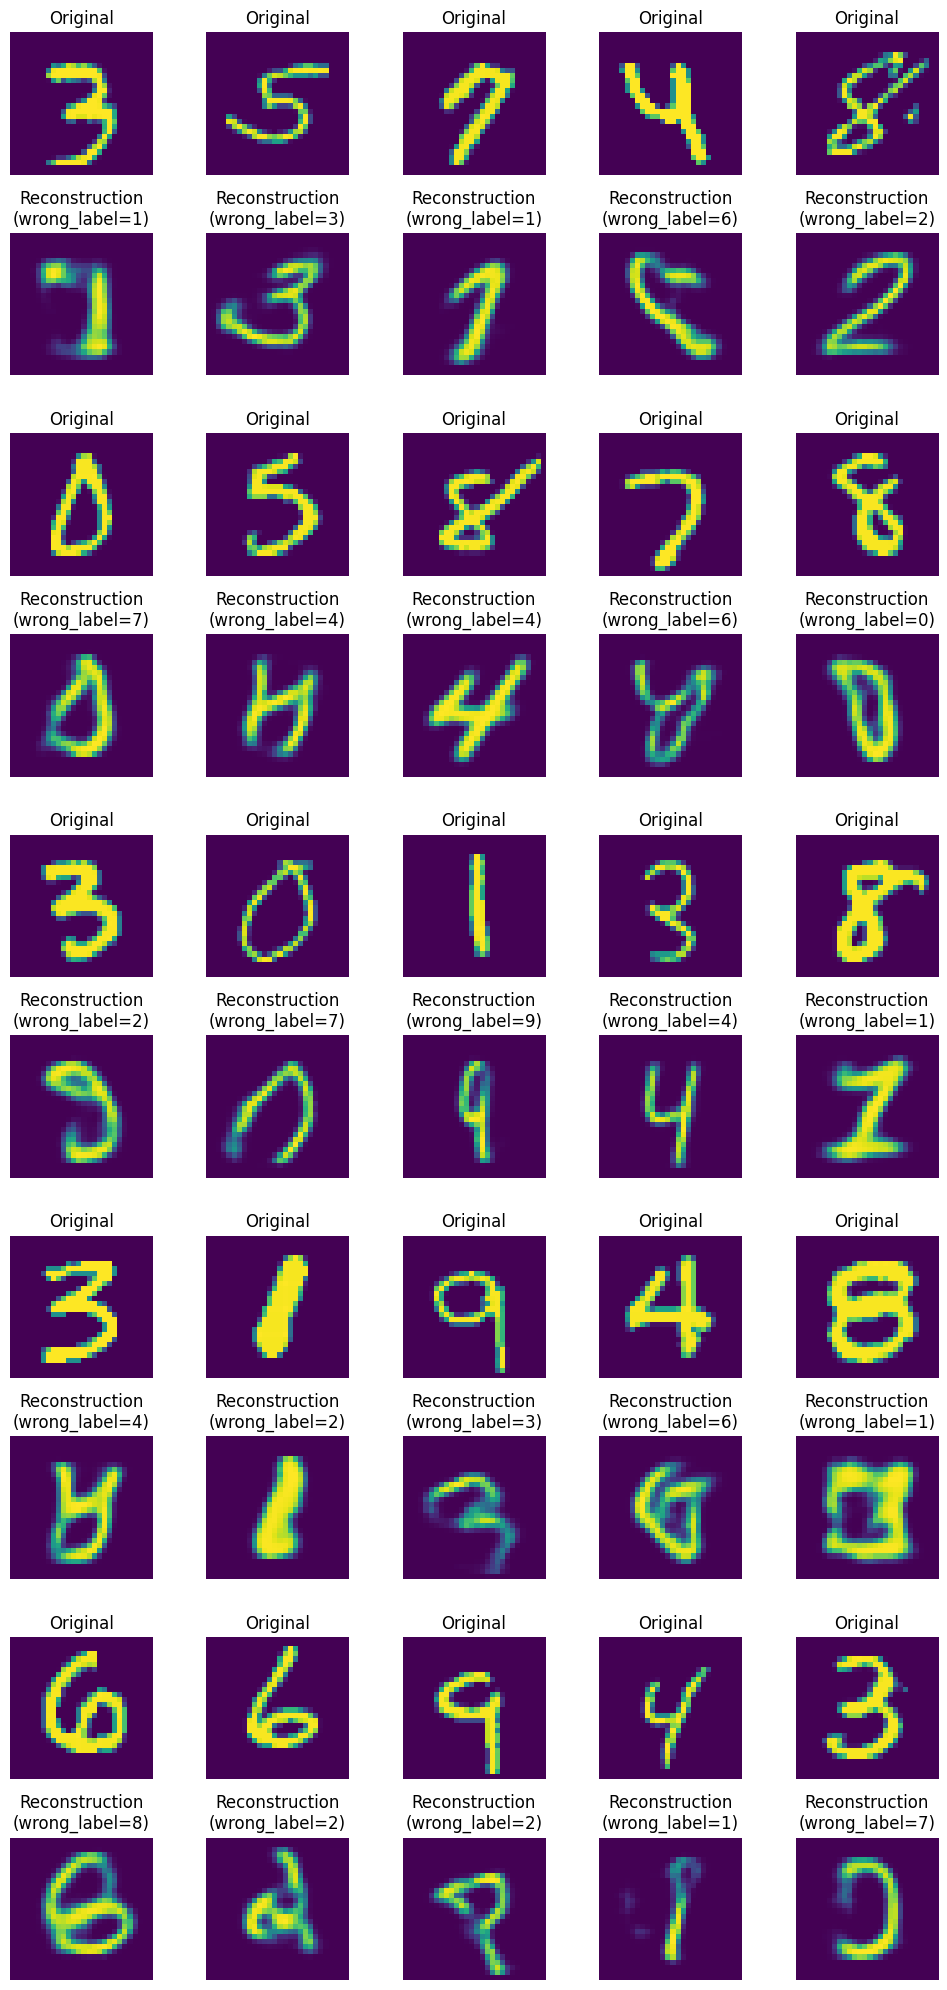

In [9]:
mnist_map = {i:i for i in range(10)}
dataset = DataSet(train_set, 28, True)
visualize(model, dataset, mnist_map)